In [1]:

import csv
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import chardet
import datetime
%matplotlib inline
testing_pred = []
testing_actual = []
#Seed
random.seed(721521789)

# Read data from the CSV into a dataframe

#get Elo data and match data
#iterate over OS path contents, and load into a dictionary/list object all elos from all leagues
raw_elo = {}
raw_matches = {}
f_HDA = {'H':0,'D':0,'A':0}
f_HDA_year_range = {'YYYY_start':-1, 'YYYY_end':-1}
f_HDA_metadata = {'Countries':[], 'Level':[]}
# default_day_HFA = "-07-22" ## 22 July YYYY is taken as the initial ELO HFA date

# #HFA updates country wide and daily - hence matches and elo updates need to be done for all teams
HFA_dict= {}

def fix_date_column(df):
    '''making the date column a time series column for easy traversal by date
    however we have 2 different date formats in our datasets

    # possible formats:
    #'%d/%m/%y'
    #'%d/%m/%Y'

    '''
    # sample_date = list(df.Date.values)
    sample_date = list(df.Date.values)
    # sample_date = (sample_date[:1])
    sample_date = sample_date[0]

    split_date = sample_date.split('/')
    if 0 <= int(split_date[2]) <= 99:
        df['Date'] =  pd.to_datetime(df['Date'], format='%d/%m/%y')  # note small 'y'
    else:
        df['Date'] =  pd.to_datetime(df['Date'], format='%d/%m/%Y')  # note capital 'Y'
    return df

#Gets all the statistics related to gameplay and elo
# bookmakers available columns
# bookmakers = ['B365', 'BS', 'BW', 'GB', 'IW', 'LB', 'PS', 'SO', 'SB', 'SJ', 'SY', 'VC', 'WH', 'BbAv']
# game_outcomes = ['H', 'D', 'A']
odds_wanted = ['B365H','B365D','B365A']

match_columns_req = ['Date','HomeTeam','AwayTeam','FTHG','FTAG','FTR']
elo_columns_req = ['Club', 'Elo']

for country in ['ENG','ESP','GER','ITA']:
    for level in [1,2]:
        for year in range(1994,2023):
            key = f"{country}\{level}\{year}" # keys are as in the following format: ENG\1\2000 etc
            path_elo = f".\\clubelo\{key}-07-22.csv"
            path_matches_trimmed = f".\\football_data_trimmed\{key}.csv"
            path_matches_untrimmed = f".\\football_data_untrimmed\{key}.csv"

            raw_elo[key] = pd.read_csv(path_elo)
            try:
                with open(path_matches_untrimmed, 'rb') as f:
                    result = chardet.detect(f.read())

                encoding = (result['encoding'])
                print(key)
                if year >= 2011:

                    cols_needed = match_columns_req+odds_wanted
                    raw_matches[key] = pd.read_csv(path_matches_untrimmed, usecols=cols_needed, encoding=encoding)
                    raw_matches[key].dropna(subset=cols_needed, inplace=True) #filtered by subset otherwise all rows with a null are removed
                else:
                    raw_matches[key] = pd.read_csv(path_matches_trimmed, delimiter=',', quoting=csv.QUOTE_ALL )
                    # raw_matches[key] = raw_matches[key].dropna()
                    raw_matches[key].dropna(subset=match_columns_req, inplace=True) #filtered by subset otherwise all rows with a null are removed
                    # print(raw_matches[key])
                raw_matches[key] = fix_date_column(raw_matches[key])
                # print(raw_matches[key])
            except FileNotFoundError:
                print(f"skipping due to lack of data {key}")

    #load HFA data
    if country not in HFA_dict.keys():
        #load HFA
        path_HFA = f".\\HFA\\{country}.csv"
        #dict in following format {"{COUNTRY}\\{YEAR}"(numeric key): [DATE, HFA_value]}
        HFA_df = pd.read_csv(path_HFA)
        HFA_df["HFA_KEY"] = HFA_df["COUNTRY"]+HFA_df["YEAR"].astype(str)
        HFA_df["DATE"] = pd.to_datetime(HFA_df['DATE'], format='%Y-%m-%d')
        for idx, row in HFA_df.iterrows():
            HFA_dict[row.HFA_KEY] = [row.HFA, row.DATE]
            print(f"loaded {country}/{row.YEAR}")

elo_data_dict = raw_elo
match_data_dict = raw_matches
# print(elo_data_dict['ENG\\1\\2000'])
for country_x in ['ENG','ESP','GER','ITA']:
    for level_x in [1,2]:
        for year_x in range(1994,2023):
            key = f"{country_x}\{level_x}\{year_x}" # keys are as in the following format: ENG\1\2000 etc
            temp = elo_data_dict[key]
            elo_data_dict[key] = temp[elo_columns_req]
            # try:
            #     temp = match_data_dict[key]
            #     match_data_dict[key] = temp[match_columns_req]
            # except KeyError:
            #     print(f"skipping due to lack of data {key}")

#elo implementation https://medium.com/mlearning-ai/how-to-calculate-elo-score-for-international-teams-using-python-66c136f01048

def k_value():
    k=20 # club elo
    return k

# matches probabilities
# frequencies_home_big_win = np.zeros((7,7)).astype(int)
# frequencies_home_margin_win = np.zeros((7,7)).astype(int)
# frequencies_home_big_loss = np.zeros((7,7)).astype(int)
# frequencies_home_margin_loss = np.zeros((7,7)).astype(int)
# frequencies_home_draw = np.zeros((7,7)).astype(int)
# frequencies_home_big_win = np.zeros((14,14)).astype(int)
# frequencies_home_margin_win = np.zeros((14,14)).astype(int)
# frequencies_home_big_loss = np.zeros((14,14)).astype(int)
# frequencies_home_margin_loss = np.zeros((14,14)).astype(int)
# frequencies_home_draw = np.zeros((14,14)).astype(int)
score_log = np.zeros((9,9)).astype(int)

# matches probabilities
frequencies_home_win = np.zeros((66,)).astype(int)
frequencies_home_loss = np.zeros((66,)).astype(int)
frequencies_home_draw = np.zeros((66,)).astype(int)
frequencies_MCS_posterior = np.zeros((380,3)).astype(int)

#https://nonleagueranking.com/rankingprocedure.html
def get_expected_outcome(elo_home,elo_away, HFA):
    '''Calculation of win probability for home and away teams
    Parameters:
    -elo_home: Elo Home
    -elo_away: Elo Away
    Returns:
    -array object:
     index 0: probability home team wins
     index 1: probability away team wins
    '''
    # print(elo_home, elo_away,HFA)
    dr=elo_home+HFA-elo_away
    E=(1/(10**(-dr/400)+1))
    # return [np.round(E,3), 1-np.round(E,3)]
    return [E, 1-E]

def get_actual_outcome(home_score, away_score):
    '''
    Get the actual result
    returns [1,0] if home team win
    returns [0,1] if home team lost
    returns [0.5, 0.5] if home team draws
    '''
    if home_score<away_score:
        return [0,1]
    elif home_score>away_score:
        return [1,0]
    elif home_score==away_score:
        return [0.5, 0.5]

# def get_simulated_outcome(simulated_outcome):
#     '''
#     Get the simulated result
#     returns [1,0] if home team win
#     returns [0,1] if home team lost
#     returns [0.5, 0.5] if home team draws
#     '''
#     if simulated_outcome == 'A':
#         return [0,1]
#     elif simulated_outcome == 'H':
#         return [1,0]
#     else:
#         #simulated outcome == 'D':
#         return [0.5, 0.5]

def get_frequency_index(elo_difference):
    "Gets an index used for logging the matches according to the ELO rating"
    if abs(elo_difference) > 450:
        return 10
    else:
        return int(abs(elo_difference) / 45)


import math
def round(elo_rank):
    #code from https://stackoverflow.com/questions/8866046/python-round-up-integer-to-next-hundred
    return int(math.ceil(elo_rank / 100.0)) * 100

# def get_rank(elo):
#     if elo >= 2100: return 6
#     elif elo < 1500: return 0
#     else:
#         return int((elo-1500)/100)
def get_rank(elo):
    if elo >= 2100: return 13
    elif elo < 800: return 0
    else:
        return int((elo-800)/100)

def get_idx(elo_home, elo_away):
    return [get_rank(elo_home), get_rank(elo_away)]



ENG\1\1994
ENG\1\1995
ENG\1\1996
ENG\1\1997
ENG\1\1998
ENG\1\1999
ENG\1\2000
ENG\1\2001
ENG\1\2002
ENG\1\2003
ENG\1\2004
ENG\1\2005
ENG\1\2006
ENG\1\2007
ENG\1\2008
ENG\1\2009
ENG\1\2010
ENG\1\2011
ENG\1\2012
ENG\1\2013
ENG\1\2014
ENG\1\2015
ENG\1\2016
ENG\1\2017
ENG\1\2018
ENG\1\2019
ENG\1\2020
ENG\1\2021
ENG\1\2022
ENG\2\1994
ENG\2\1995
ENG\2\1996
ENG\2\1997
ENG\2\1998
ENG\2\1999
ENG\2\2000
ENG\2\2001
ENG\2\2002
ENG\2\2003
ENG\2\2004
ENG\2\2005
ENG\2\2006
ENG\2\2007
ENG\2\2008
ENG\2\2009
ENG\2\2010
ENG\2\2011
ENG\2\2012
ENG\2\2013
ENG\2\2014
ENG\2\2015
ENG\2\2016
ENG\2\2017
ENG\2\2018
ENG\2\2019
ENG\2\2020
ENG\2\2021
ENG\2\2022
loaded ENG/1993
loaded ENG/1994
loaded ENG/1995
loaded ENG/1996
loaded ENG/1997
loaded ENG/1998
loaded ENG/1999
loaded ENG/2000
loaded ENG/2001
loaded ENG/2002
loaded ENG/2003
loaded ENG/2004
loaded ENG/2005
loaded ENG/2006
loaded ENG/2007
loaded ENG/2008
loaded ENG/2009
loaded ENG/2010
loaded ENG/2011
loaded ENG/2012
loaded ENG/2013
loaded ENG/2014
loaded ENG

In [2]:

def get_rps_HDA(f_prob, o_true):
    """Adapted from https://opisthokonta.net/?p=1333"""
    ncat = f_prob.shape[1]
    npred = f_prob.shape[0]

    rps = np.zeros(npred)

    for rr in range(npred):
        cumulative = 0
        for i in range(0,ncat):
            cumulative += (np.sum(f_prob[rr, 0:i+1]) - np.sum(o_true[rr, 0:i+1])) ** 2
        rps[rr] = (1/(ncat-1))*cumulative
    # print(rps)
    return rps


def get_brier_score_and_rps(o_true, f_prob):
    """
    Calculate the multi-class Brier score for home win/draw/loss for the matches played.

    Parameters:
    y_true one-hot encoded 2D array
    y_prob predicted probabilities for each class stored in a 2D array

    Returns:
    brier_score (float): the multi-class Brier score
    """

    # Convert to numpy arrays
    o_true = np.array(o_true)
    f_prob = np.array(f_prob)

    # Calculate the squared difference between the predicted probabilities and the true classes
    squared_diff = np.sum((f_prob - o_true) ** 2, axis=1)

    # Calculate the mean squared difference, i.e. the Brier Score
    brier_score = np.mean(squared_diff)

    # Calculate RPS

    # Sum up the squared differences for each rank and divide by n
    rps = get_rps_HDA(f_prob, o_true)

    # rps_avg = (1/len(rps))*np.sum(np.array(rps))
    rps_avg = np.mean(np.array(rps))

    # rps_avg = rps['H']+rps['D']+rps['A']/3
    # Return the Brier score & RPS values
    return brier_score, rps, rps_avg

def get_one_hot_encoded(outcome):
    """
    Converts HDA to a one hot encoded outcome.

    :param outcome: either 'H', 'D', or 'A'
    :return:
        3 bit number, as a list object
    """
    if outcome == 'H':
        return [1, 0, 0]
    elif outcome == 'A':
        return [0, 0, 1]
    else:
        #outcome == 'D'
        return [0, 1, 0]


In [3]:

def calculate_elo(elo_home, elo_away, HFA, home_score, away_score, count_frequencies=False, simulation=False):
    k = k_value()
    # actual_outcome = get_actual_outcome(home_score,away_score)
    # home_win, away_win = actual_outcome[0],actual_outcome[1]
    # print(f"{elo_home} vs {elo_away} calculating elo")
    home_win, away_win = get_actual_outcome(home_score,away_score)
    p_home_win, p_away_win = get_expected_outcome(elo_home, elo_away, HFA)
    # print(f"{p_home_win} {p_away_win}")
    idx_home, idx_away = get_idx(elo_home,elo_away)
    if home_win == 0.5:
        #old elo point exchange (no weighting goal diff as margin is 0)
        new_elo_home = elo_home + k*(home_win-p_home_win)
        new_elo_away = elo_away + k*(away_win-p_away_win)
    else:
        margin = abs(home_score-away_score)
        deltaElo = k*(home_win-p_home_win)
        deltaElo_1goal = deltaElo/(get_weighted_sum_over_margin( home_score, away_score))
        # print(HFA)
        #new elo point exchange must be considered (weighted goal diff)
        new_elo_home = elo_home + (deltaElo_1goal*math.sqrt(margin))
        new_elo_away = elo_away - (deltaElo_1goal*math.sqrt(margin))
        # new_elo_away = elo_away + k*(away_win-p_away_win)
    #
    # if not simulated:
    if count_frequencies and not simulation:
        # log frequencies to get probabilities according to the difference
        # if count_frequencies:
        ratio = elo_home/elo_away
        idx = bucket_ratio(round_2dp(ratio))
        if home_win == 0:
            frequencies_home_loss[idx]+=1
        elif home_win == 1:
            frequencies_home_win[idx]+=1
        elif home_win == 0.5:
            frequencies_home_draw[idx]+=1

    return new_elo_home, new_elo_away


def update_points(current_points, simulated_outcome, home_team, away_team):
    # Set initial points to home/away team to 0 if not set
    if home_team not in current_points.keys():
        current_points[home_team] = 0
    if away_team not in current_points.keys():
        current_points[away_team] = 0

    #calculating and updating points
    if simulated_outcome == 'H':
        current_points[home_team] += 3
    elif simulated_outcome == 'A':
        current_points[away_team] += 3
    else:
        # game drawn
        current_points[home_team] += 1
        current_points[away_team] += 1
    # print(current_points)
    return current_points

def round_2dp(ratio):
    return math.ceil(ratio*100)/100

def bucket_ratio(rounded_ratio):

    if rounded_ratio < 0.7:
        return 0
    elif rounded_ratio >= 1.35:
        return 65 # 65?
    else:
        #y= 0.01x+0.7
        return int((rounded_ratio-.7)/0.01)

In [4]:


def get_weighted_sum_over_margin(home_score, away_score):
    margin = home_score-away_score
    if margin < 0:
        # team lost
        margin = abs(margin)
        ftr = 'A'
        # p_1x2 = get_p_1x2(margin,ftr)*p_away_win
        p_1x2 = get_p_1x2(margin,ftr)
        # p_1x2 = p_away_win
    else:
        ftr = 'H'
        # p_1x2 = get_p_1x2(margin,ftr)*p_home_win
        p_1x2 = get_p_1x2(margin,ftr)
        # p_1x2 = p_home_win
    sum_margins = 0
    # e.g.: if the margin is 8, then get 0-8 and 8-0 margins
    # scores = get_all_possible_scores(margin)
    #
    # # get weighted goal diff
    # for score in scores:
    #     s_home, s_away = int(score[0]), int(score[1]) # holds scores
    #     p_margin = score_log[s_home, s_away]/np.sum(score_log)
    #     sum_margins = sum_margins + (math.sqrt(margin)*p_margin/p_1x2)
    for i in range(1,9):
        scores = get_all_possible_scores(i)
        # print(i, scores)
        for score in scores:
            s_home, s_away = int(score[0]), int(score[1]) # holds scores
            p_margin = score_log[s_home, s_away]/np.sum(score_log)
            sum_margins = sum_margins + (math.sqrt(i)*p_margin/p_1x2)

    return sum_margins

def get_all_possible_scores(margin, ftr='H', reverse_score=False):
    home = np.arange(0,9-margin,1)
    away = np.arange(margin,9, 1)

    if ftr=='H':
        a=home
        b=away
    else:
        a=away
        b=home

    margins = []
    #generate margin list
    for i in range(0, len(a)):
        # save both permutations of the scores
        margins.append([a[i],b[i]])
        if margin != 0 or reverse_score == True:
            margins.append([b[i],a[i]])
    # print(margins)
    return margins


def get_p_1x2(margin, ftr):
    ftr_scores = get_all_possible_scores(margin, ftr, True)
    f_ftr = 0
    for score in ftr_scores:
        s_home, s_away = int(score[0]), int(score[1]) # holds scores
        f_ftr += score_log[s_home, s_away]
    # print(f_ftr/np.sum(score_log))
    return f_ftr/np.sum(score_log)



def simulate_outcome_on_elo_rank_frequencies(elo_home, elo_away, o_true, f_prob):
    elo_ranks = get_idx(elo_home, elo_away)
    rank_h, rank_a = elo_ranks[0],elo_ranks[1]

    ratio = elo_home/elo_away
    idx = bucket_ratio(round_2dp(ratio))
    # p_home_win_over_x_season_[idx]
    # p_home_win[idx]
    # p_home_win[idx]
    total = frequencies_home_win[idx]+frequencies_home_loss[idx]+frequencies_home_draw[idx]
    if total != 0:
        # use league rank vs rank probabilities
        p_H = frequencies_home_win[idx]/total
        p_A = frequencies_home_loss[idx]/total
        p_D = frequencies_home_draw[idx]/total
    else:
        # get league HAD probabilities
        total = np.sum(frequencies_home_win)+np.sum(frequencies_home_loss)+np.sum(frequencies_home_draw)
        p_H = np.sum(frequencies_home_win)/total
        p_A = np.sum(frequencies_home_loss)/total
        p_D = np.sum(frequencies_home_draw)/total

    # get forecasted outcome
    forecasted_outcome = random.choices(['H','A','D'], weights=(p_H*100,p_A*100,p_D*100), k=1)[0]

    # append to list
    f_prob.append([p_H, p_D, p_A])
    o_true.append(get_one_hot_encoded(forecasted_outcome))


    # print((p_H*100,p_A*100,p_D*100))
    # print(random.choices(['H','A','D'], weights=(p_H*100,p_A*100,p_D*100), k=1))
    return forecasted_outcome, o_true, f_prob

def plot_rps(x_axis, y_axis, title, x_label, y_label):
    # plt.
    plt.plot(x_axis, y_axis, color ='maroon')
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.axhline(y=np.mean(np.array(y_axis)), color ='blue')
    plt.show()
#
# def get_simulated_balances(simulated_outcome):
#     # print(frequencies_MCS_posterior)
#     # prob_MCS_matches = frequencies_MCS_posterior / np.sum(frequencies_MCS_posterior, axis=1, keepdims=True) # axis = 1 sums each row separately, keep dims = keeps same dimensions, otherwise we get a sum per row
#
#     # max_indices = np.argmax(prob_MCS_matches, axis=1) # get indices of maximum values
#     # bets_outcome = (np.eye(prob_MCS_matches.shape[1])[max_indices]).astype(int) # one hot encode marked indices - we will take the highest occurring outcome and bet upon it
#
#     BET_EURO = 10 # everytime we bet 10 euro
#     balance = 1000 # we have 1000 euro in our bank
#
#     potential_payout = np.array(simulated_outcome) * bet365_odds * BET_EURO
#     pay_out = potential_payout * observed
#     balance_forecasted_season = []
#     for pay in pay_out:
#         balance -= 10
#         balance += np.sum(pay)
#         balance_forecasted_season.append(balance)
#     return balance_forecasted_season
#     # plot_multiplelines(range(0,len(balance_historical),1), balance_historical, "Balance of the simple betting model", "Game number", "Balance")
# def get_simulated_balances(forecasted,simulated_outcome):
#     # print(frequencies_MCS_posterior)
#     # prob_MCS_matches = frequencies_MCS_posterior / np.sum(frequencies_MCS_posterior, axis=1, keepdims=True) # axis = 1 sums each row separately, keep dims = keeps same dimensions, otherwise we get a sum per row
#
#     # max_indices = np.argmax(prob_MCS_matches, axis=1) # get indices of maximum values
#     max_forecasted = np.argmax(forecasted, axis=1) # get indices of maximum values
#     # bets_outcome = (np.eye(prob_MCS_matches.shape[1])[max_indices]).astype(int) # one hot encode marked indices - we will take the highest occurring outcome and bet upon it
#     # bets_outcome = (np.eye(f.shape[1])[max_indices]).astype(int) # one hot encode marked indices - we will take the highest occurring outcome and bet upon it
#
#     BET_EURO = 10 # everytime we bet 10 euro
#     balance = 1000 # we have 1000 euro in our bank
#
#     # potential_payout = np.array(simulated_outcome) * bet365_odds * BET_EURO
#     potential_payout = np.array(forecasted) * bet365_odds * BET_EURO
#     pay_out = potential_payout * simulated_outcome
#     # pay_out = potential_payout * observed
#     balance_forecasted_season = []
#     for pay in pay_out:
#         balance -= 10
#         balance += np.sum(pay)
#         balance_forecasted_season.append(balance)
#     return balance_forecasted_season
    # plot_multiplelines(range(0,len(balance_historical),1), balance_historical, "Balance of the simple betting model", "Game number", "Balance")

def get_simulated_balances(strategy_name,forecasted, actual_outcomes):

    max_indices = np.argmax(forecasted, axis=1) # get indices of maximum values
    # print(max_indices)
    BUDGET_MATCH_EURO = 10 # everytime we bet 10 euro

    balance = len(forecasted) * BUDGET_MATCH_EURO
    balance_forecasted_season = []

    bet365 = np.array(bet365_odds)

    f_p = np.array(forecasted)
    bet_euro = BUDGET_MATCH_EURO
    forecasted_outcome = (np.eye(f_p.shape[1])[max_indices]).astype(int) #
    observed_outcome = np.array(actual_outcomes)
    # print(forecasted_outcome)


    if strategy_name == 'Simple':
        potential_payout = forecasted_outcome * bet_euro * bet365
        pay_out = potential_payout * observed_outcome

        for pay in pay_out:
            balance -= bet_euro
            balance += np.sum(pay)
            balance_forecasted_season.append(balance)
    else:
        #strategy name =='Kelly'
        potential_payout = np.zeros((len(forecasted_outcome),3)).astype(float)
        pay_out = np.zeros((len(forecasted_outcome),3)).astype(float)
        idx_match = 0
        for match_res in max_indices:
            # get max probability
            bet_euro = BUDGET_MATCH_EURO
            idx_outcome = match_res
            odds = bet365[idx_match][idx_outcome]
            p_odd_true = f_p[idx_match][idx_outcome]
            # print(f"odds:{bet365[idx_match]}")
            # print(f"freq:{f_p[idx_match]}")
            stake = ((odds * p_odd_true) - (1-p_odd_true))/odds ##
            # print(f"stake:{stake}")
            bet_euro = bet_euro * stake
            # print(f"bet_euro:{bet_euro * stake}")
            potential_payout[idx_match,idx_outcome] = bet_euro * odds
            pay_out[idx_match,idx_outcome] = potential_payout[idx_match,idx_outcome]
            balance -= bet_euro # within match context
            balance += pay_out[idx_match,idx_outcome] # potential_payout[idx_match,idx_outcome]
            balance_forecasted_season.append(balance)
            idx_match += 1

    return balance_forecasted_season
bet365_odds = []
observed = []


def plot_balances_simulated(x_axis, y_axis, title, x_label, y_label):
    # plt.
    for y_list in y_axis:
        color = ""
        last_bal = y_list[-1]
        if last_bal < 1000:
            color += "red"
        elif last_bal > 1000:
            color += "green"
        else:
            # sum_y == 1000
            color += "blue"
        plt.plot(x_axis, y_list, color=color)
        colour = ''
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.axhline(y=np.mean(np.array(y_axis)), color ='black')
    plt.show()

def calculate_HFA(dict, additional_results, count_frequencies, current_elo, league, lvl, season, match_date, should_update):
    '''
        HFA calculation according to the last update date
        if HFA is already calculated return it.
        or if HFA needs to be recalculated
    '''
    data_HFA = dict[f"{league}{season-1}"]
    last_HFA = data_HFA[0]
    last_update = data_HFA[1]

    # if not should_update:
    if match_date <= last_update:
        # HFA already calculated
        # print(f"last HFA update: {last_HFA} @ {pd.to_datetime(np.datetime64(last_update)).date()}")
        return last_HFA, current_elo, dict
    else:
        # new_HFA = 0
        # get all records from other division between last update and current match date - this is to get the full view over a particular country
        if lvl == 1:
            # we need to consider matches from the second division
            value = 2
        else:
            # we need to consider matches from the upper first division
            value = 1

        df = match_data_dict[f"{league}\\{value}\\{season}"]
        matches = df.query('Date >= @last_update and Date < @match_date') # we want to include matches in the last date of update but don't want the last matches of the current date (as otherwise the actual results to be predicted will be considered https://sparkbyexamples.com/pandas/pandas-select-dataframe-rows-between-two-dates/

        days = matches['Date']
        dates_secondary = np.array(list(days.unique()), dtype='datetime64')
        dates_main = np.array(list(additional_results.keys()), dtype='datetime64')

        unique_days = np.concatenate([dates_secondary, dates_main])
        unique_days = np.sort(unique_days, axis=0)

        for day in unique_days:
            #get needed matches
            daily_matches = matches.query('Date == @day')

            # if simulation:
            #     count_frequencies = False
            # else:
            #     count_frequencies = True
            # get matches from secondary league (if any)
            results, current_elo = get_sum_of_all_points_exchanged_on_a_particular_day(daily_matches, league, season, current_elo, last_HFA, count_frequencies)

            #get matches from main league (if any)
            if day in additional_results.keys():
                if day in results.keys():
                    # if day is present in both dicts, concat lists
                    results[day] += additional_results[day]
                else:
                    # day has matches from main league but no matches from secondary league
                    results[day] = additional_results[day]
            else:
                if day in results.keys():
                    # no matches from main league, matches come only from secondary league
                    pass
                else:
                    # no games in main or secondary leagues for a particular day
                    results[day] = [0]

            # print(f"Total point exchange: {results} {sum(results)}")
            # update HFA dictionary with new HFA and updated HFA date
            last_HFA = last_HFA + (sum(results[day])*0.075)
            last_update = day
            new_HFA = last_HFA

            if np.where(day == unique_days[-1]):
                last_update=match_date
            dict[f"{league}{season-1}"] = [new_HFA, last_update]

        # print(f"new HFA update {pd.to_datetime(np.datetime64(last_update)).date()}: {last_HFA}\n")
        return last_HFA, current_elo, dict


def plot_graph(x_axis, y_axis, title, x_label, y_label):
    # plt.
    plt.bar(x_axis, y_axis, color ='maroon',
            width = 0.01)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


In [5]:

def get_sum_of_all_points_exchanged_on_a_particular_day(df, league, season, current_elo, HFA, count_frequencies):
    results = {}
    for idx_match, match in df.iterrows():
        # df.iloc[idx_match]
        # new_elo_home, elo_home, current_elo = play_match_on_a_particular_day(match, league, season, current_elo, HFA, count_frequencies, p_1x2_are_set)

        # Getting the data that it is nedeed to calculate the elo

        home_team=match["HomeTeam"]
        away_team=match["AwayTeam"]
        home_score=match['FTHG']
        away_score=match['FTAG']
        actual_outcome=match['FTR']

        key1 = f"{league}\\1\\{season-1}"
        key2 = f"{league}\\2\\{season-1}"
        tmp_df1 = elo_data_dict[key1]
        tmp_df2 = elo_data_dict[key2]

        # Getting elo before match. If it is the first match played, the elo is initialized to 1400.
        if home_team not in current_elo.keys():
            # fetch team from ENG\\1\\YYYY and if not present fetch it from ENG\\2\\YYYY
            first_league_elo = tmp_df1[tmp_df1.apply(lambda x: (x["Club"]==home_team), axis=1)]
            second_league_elo = tmp_df2[tmp_df2.apply(lambda x: (x["Club"]==home_team), axis=1)]

            if first_league_elo.empty and second_league_elo.empty:
                print(home_team)
                # value =  1400 # TODO: Revise this and change for diff leagues
                # value = tmp_df2["Elo"].min()
                value = get_value(home_team, tmp_df1,tmp_df2)
                # value = np.average(current_elo.values()) # TODO: Revise this and change for diff leagues
            else:
                if first_league_elo.empty:
                    value = second_league_elo["Elo"].sum()
                else:
                    value = first_league_elo["Elo"].sum()

            current_elo[home_team] = value

        tmp_df1 = elo_data_dict[key1]
        tmp_df2 = elo_data_dict[key2]
        # Getting elo before match. If it is the first match played, the elo is initialized to 1400.
        if away_team not in current_elo.keys():
            # fetch team from ENG\\1\\YYYY and if not present fetch it from ENG\\2\\YYYY
            first_league_elo = tmp_df1[tmp_df1.apply(lambda x: (x["Club"]==away_team), axis=1)]
            second_league_elo = tmp_df2[tmp_df2.apply(lambda x: (x["Club"]==away_team), axis=1)]

            if first_league_elo.empty and second_league_elo.empty:
                print(away_team)
                # value = 1400 # TODO: Revise this
                # value = tmp_df2["Elo"].min() # TODO: Revise this
                # print(value)
                value = get_value(away_team, tmp_df1, tmp_df2)
                # value = np.average(current_elo.values()) # TODO: Revise this
            else:
                if first_league_elo.empty:
                    # print(second_league_elo)
                    value = second_league_elo["Elo"].sum()
                else:
                    # print(first_league_elo)
                    value = first_league_elo["Elo"].sum()

            current_elo[away_team] = value

        #calculating and updating elo
        elo_home=current_elo[home_team]
        elo_away=current_elo[away_team]
        # if simulation:
        #     simulated_outcome, o_true, f_prob = simulate_outcome_on_elo_rank_frequencies(current_elo[home_team],current_elo[away_team], o_true, f_prob)
        #     current_points = update_points(current_points, simulated_outcome, home_team, away_team)
        #     # new_elo_home,new_elo_away=calculate_simulated_elo(elo_home,elo_away,simulated_outcome)
        #     new_elo_home,new_elo_away=calculate_elo(elo_home,elo_away,HFA, home_score,away_score, count_frequencies=False)
        #
        #     testing_pred.append(simulated_outcome)
        #     testing_actual.append(actual_outcome)
        # else:
        #     #calculate elo
        new_elo_home,new_elo_away=calculate_elo(elo_home,elo_away, HFA, home_score,away_score, count_frequencies=count_frequencies, simulation=False)

        #update scores
        update_scores(home_score, away_score)

        #update ELO
        current_elo[home_team]=new_elo_home
        current_elo[away_team]=new_elo_away

        points_exchanged = new_elo_home-elo_home
        # date = np.datetime64(datetime.datetime.fromtimestamp(match['Date']))
        date = np.datetime64(pd.to_datetime(match['Date'])).astype('datetime64[ns]')
        if date not in results.keys():
            results[date] = [points_exchanged]
        else:
            results[date].append(points_exchanged) # points exchanged for home team

    return results, current_elo

Score data loaded!
{'H': 24821, 'D': 15049, 'A': 14072}
GER 2014-2015 1
306
305
GER 2015-2016 1
306
306
GER 2016-2017 1
306
306
Iteration: 1/2500
Iteration: 2/2500
Iteration: 3/2500
Iteration: 4/2500
Iteration: 5/2500
Iteration: 6/2500
Iteration: 7/2500
Iteration: 8/2500
Iteration: 9/2500
Iteration: 10/2500
Iteration: 11/2500
Iteration: 12/2500
Iteration: 13/2500
Iteration: 14/2500
Iteration: 15/2500
Iteration: 16/2500
Iteration: 17/2500
Iteration: 18/2500
Iteration: 19/2500
Iteration: 20/2500
Iteration: 21/2500
Iteration: 22/2500
Iteration: 23/2500
Iteration: 24/2500
Iteration: 25/2500
Iteration: 26/2500
Iteration: 27/2500
Iteration: 28/2500
Iteration: 29/2500
Iteration: 30/2500
Iteration: 31/2500
Iteration: 32/2500
Iteration: 33/2500
Iteration: 34/2500
Iteration: 35/2500
Iteration: 36/2500
Iteration: 37/2500
Iteration: 44/2500
Iteration: 38/2500
Iteration: 39/2500
Iteration: 40/2500
Iteration: 41/2500
Iteration: 42/2500
Iteration: 43/2500
Iteration: 45/2500
Iteration: 46/2500
Iterati

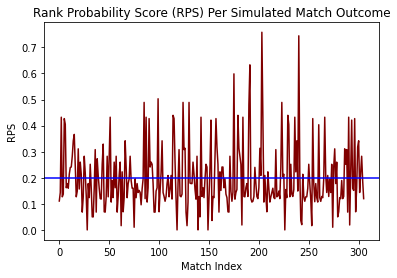

             Team  Simulated Average Points
1   Bayern Munich                   75.6248
2        Dortmund                   61.2976
3      Hoffenheim                   52.8712
4      M'gladbach                   50.5976
5      Schalke 04                   50.5792
6      RB Leipzig                   49.5948
7      Leverkusen                   49.2096
8   Werder Bremen                   45.7236
9          Hertha                   44.2820
10      Wolfsburg                   43.4100
11  Ein Frankfurt                   42.7456
12       Freiburg                   42.7064
13        FC Koln                   42.0228
14       Augsburg                   41.6160
15          Mainz                   39.1096
16       Hannover                   37.3112
17        Hamburg                   36.3996
18      Stuttgart                   36.0748


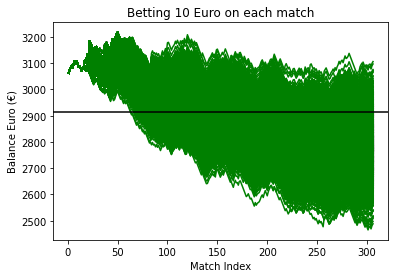

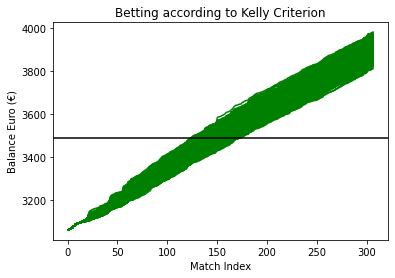

C:\Users\steve\AppData\Local\Temp/ipykernel_33504/2878779942.py:274: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  f_HDA_metadata_array = np.array([f_HDA_metadata[k] for k in f_HDA_metadata])


In [6]:



# def play_match_on_a_particular_day(o_true, f_prob, simulation, match, league, season, current_elo, HFA, count_frequencies):
#
#
#     # print(f"Home new & old elo {new_elo_home} {elo_home} ")
#     # print(f"Away new & old elo {new_elo_away} {elo_away} \n")
#     # print(f"Score {home_score} - {away_score} \n")
#     return new_elo_home, elo_home, current_elo, current_points, o_true, f_prob
from Levenshtein import distance

def levenshtein_distance(s1, s2):
    return distance(s1, s2)
# create a new column in df1 with the closest match from df2
def find_closest_match(team_name, df):
    """Given a df, the closest team name (if any) is found and returned"""
    try:
        closest_match = min(df['Club'], key=lambda x: levenshtein_distance(team_name, x))
    except ValueError:
        closest_match = None
    return closest_match

def get_value(team, tmp_df1, tmp_df2):
    """calculate levenshtein distance of the team to the ELO dataframes...
    if no team names are close, then simply take the min value of the secondary league, as the team may have been promoted from other leagues not considered in the elo calculation.

     :params:
        team: string name of club/team playing at home or away
        tmp_df1:elo dataframe of main league
        tmp_df2:elo dataframe of secondary league
     """
    closest_match_df1 = find_closest_match(team, tmp_df1)
    closest_match_df2 = find_closest_match(team, tmp_df2)

    if closest_match_df1 == closest_match_df2 and closest_match_df2 is None:
        value = tmp_df2["Elo"].min()
    else:

        first_league_elo = tmp_df1[tmp_df1.apply(lambda x: (x["Club"]==closest_match_df1), axis=1)]
        second_league_elo = tmp_df2[tmp_df2.apply(lambda x: (x["Club"]==closest_match_df2), axis=1)]
        if closest_match_df1 is None:
            value = second_league_elo["Elo"].sum()
        else:
            value = first_league_elo["Elo"].sum()

    return value

def update_procedure(index_match, o_true, f_prob, simulation, current_elo, current_points, Country, Year, home_team, away_team, HFA, home_score, away_score, actual_outcome='X'):

    key1 = f"{Country}\\1\\{Year-1}"
    key2 = f"{Country}\\2\\{Year-1}"
    tmp_df1 = elo_data_dict[key1]
    tmp_df2 = elo_data_dict[key2]

    # Getting elo before match. If it is the first match played, the elo is initialized to 1400.
    if home_team not in current_elo.keys():
        # fetch team from ENG\\1\\YYYY and if not present fetch it from ENG\\2\\YYYY
        first_league_elo = tmp_df1[tmp_df1.apply(lambda x: (x["Club"]==home_team), axis=1)]
        second_league_elo = tmp_df2[tmp_df2.apply(lambda x: (x["Club"]==home_team), axis=1)]

        if first_league_elo.empty and second_league_elo.empty:
            # print(home_team)
            value = get_value(home_team, tmp_df1, tmp_df2)
            # value = np.average(current_elo.values()) # TODO: Revise this and change for diff leagues
        else:
            if first_league_elo.empty:
                value = second_league_elo["Elo"].sum()
            else:
                value = first_league_elo["Elo"].sum()

        current_elo[home_team] = value

    tmp_df1 = elo_data_dict[key1]
    tmp_df2 = elo_data_dict[key2]
    # Getting elo before match. If it is the first match played, the elo is initialized to 1400.
    if away_team not in current_elo.keys():
        # fetch team from ENG\\1\\YYYY and if not present fetch it from ENG\\2\\YYYY
        first_league_elo = tmp_df1[tmp_df1.apply(lambda x: (x["Club"]==away_team), axis=1)]
        second_league_elo = tmp_df2[tmp_df2.apply(lambda x: (x["Club"]==away_team), axis=1)]

        if first_league_elo.empty and second_league_elo.empty:
            # print(away_team)
            # value = 1400 # TODO: Revise this
            value = get_value(away_team, tmp_df1, tmp_df2)
            # print(value)
            # value = np.average(current_elo.values()) # TODO: Revise this
        else:
            if first_league_elo.empty:
                # print(second_league_elo)
                value = second_league_elo["Elo"].sum()
            else:
                # print(first_league_elo)
                value = first_league_elo["Elo"].sum()

        current_elo[away_team] = value

    #calculating and updating elo
    elo_home=current_elo[home_team]
    elo_away=current_elo[away_team]
    if simulation:
        simulated_outcome, o_true, f_prob = simulate_outcome_on_elo_rank_frequencies(current_elo[home_team],current_elo[away_team], o_true, f_prob)
        current_points = update_points(current_points, simulated_outcome, home_team, away_team)
        # new_elo_home,new_elo_away=calculate_simulated_elo(elo_home,elo_away,simulated_outcome)

        sampling_frequencies = []
        sampling_score_list = []
        for home_idx in range(0,9):
            for away_idx in range(0,9):
                if simulated_outcome == 'H':
                    if home_idx > away_idx:
                        sampling_score_list.append([home_idx,away_idx])
                        sampling_frequencies.append(score_log[home_idx,away_idx])
                elif simulated_outcome == 'A':
                    if home_idx < away_idx:
                        sampling_score_list.append([home_idx,away_idx])
                        sampling_frequencies.append(score_log[home_idx,away_idx])
                else:
                    # simulated_outcome == 'D'
                    if home_idx == away_idx:
                        sampling_score_list.append([home_idx,away_idx])
                        sampling_frequencies.append(score_log[home_idx,away_idx])


        sampling_frequencies = np.array(sampling_frequencies)
        sampling_probabilities = sampling_frequencies/np.sum(sampling_frequencies)

        # necessary for the elo calculation
        sampled_score = random.choices(sampling_score_list, sampling_probabilities)[0]
        # print(f"{simulated_outcome}: sampled {sampled_score}")
        sampled_home_score = sampled_score[0]
        sampled_away_score = sampled_score[1]

        new_elo_home,new_elo_away=calculate_elo(elo_home,elo_away,HFA, sampled_home_score, sampled_away_score, count_frequencies=False, simulation=True)

        # testing_pred.append(simulated_outcome)
        # testing_actual.append(actual_outcome)
    else:
        #calculate elo
        new_elo_home,new_elo_away=calculate_elo(elo_home,elo_away, HFA, home_score,away_score, count_frequencies=True, simulation=False)

        #update scores # TODO: EXPERIMENT IF INDENTED OR NOT, and should we have update scores above?
        update_scores(home_score, away_score)

    #update ELO
    current_elo[home_team]=new_elo_home
    current_elo[away_team]=new_elo_away

    # print(f"{home_team} vs {away_team}: {home_score}-{away_score}: old elos {elo_home} {elo_away} new elos: {new_elo_home} {new_elo_away}\n")
    return current_elo, current_points, o_true, f_prob, new_elo_home, elo_home

def play_k_matches(simulation = True, Country='ENG', Level='1', k=20000, YYYY_start = 2021, YYYY_end=2022):
    simulated_points={}
    all_points = {}
    simulated_simple_balance=[]
    simulated_kelly_balance=[]
    o_true, f_prob = [], []

    local_HFA_dict = dict(HFA_dict)

    for z in range(0,k):
        simulation_HFA = dict(local_HFA_dict)
        outcomes_simulated = []

        print(f"Iteration: {z+1}/{k}")

        # print(simulation_HFA)
        for YYYY in range(YYYY_start, YYYY_end):
            current_simulation_HFA = {}
            # Creating the empty dictionary that is going to store the current elo for each national team
            current_elo={}
            current_points={}
            o_true, f_prob = [],[]

            #keep log of last HFA update
            last_match_date = -1
            current_match_date = -1
            results = {}
            should_update = True
            df = match_data_dict[f"{Country}\\{Level}\\{YYYY}"].reset_index()
            # df.head(10)
            for idx,row in df.iterrows():

                # print("Local",local_HFA_dict[f"{Country}{YYYY-1}"])
                # print("Simulation",simulation_HFA[f"{Country}{YYYY-1}"])
                # Getting the data that it is needed to calculate the elo
                match_date = df.iloc[idx]['Date']
                home_team=df.iloc[idx]["HomeTeam"]
                away_team=df.iloc[idx]["AwayTeam"]
                home_score=df.iloc[idx]['FTHG']
                away_score=df.iloc[idx]['FTAG']
                actual_outcome = df.iloc[idx]['FTR']

                if last_match_date == -1:
                    last_match_date = simulation_HFA[f"{Country}{YYYY-1}"][1]

                if current_match_date == -1:
                    current_match_date = match_date

                # print(should_update)
                # Update HFA, if necessary
                HFA, current_elo, simulation_HFA = calculate_HFA(dict(simulation_HFA), results, False, current_elo, Country, Level, YYYY, current_match_date, should_update)
                # print(HFA, match_date)
                if should_update:
                    results = {}

                current_elo, current_points, o_true, f_prob, new_elo_home, elo_home = update_procedure(idx, o_true, f_prob, True, current_elo, current_points, Country, YYYY, home_team, away_team, HFA, home_score,away_score)
                #append observed
                outcomes_simulated.append(o_true[-1])

                points_exchanged = new_elo_home-elo_home
                date = match_date
                if date not in results.keys():
                    results[date] = [points_exchanged]
                else:
                    results[date].append(points_exchanged) # points exchanged for home team
                # results.append(points_exchanged) # points exchanged for home team

                if current_match_date <= last_match_date:
                    should_update = False
                    current_match_date = -1
                else:
                    should_update = True
                    last_match_date = -1
                if z == 0:
                    bet365_odds.append([row['B365H'],row['B365D'],row['B365A']])

                    observed.append(get_one_hot_encoded(actual_outcome))

                # simulation_HFA = current_simulation_HFA
            #match statistics saving
            #save sum of all points obtained by each team over k iterations
            for team in current_points.keys():
                if team not in simulated_points.keys():
                    # simulated_points[team] = []
                    simulated_points[team] = 0
                    all_points[team] = []
                else:
                    # simulated_points[team].append(tmp_points[team])
                    simulated_points[team] += current_points[team]
                    all_points[team].append(current_points[team])
                    if z == k-1:
                        #avg points
                        simulated_points[team] /= k
            # print(simulation_HFA)

        simulated_simple_balance.append(get_simulated_balances("Simple",f_prob, observed))
        simulated_kelly_balance.append(get_simulated_balances("Kelly",f_prob, observed))

    brier_score, rps_all, rps_avg = get_brier_score_and_rps(o_true, f_prob)
    print(f"Brier Score {brier_score} for {Country}1 : {YYYY_start-1}-{YYYY_end-1} season")
    print(f"RPS_avg {rps_avg} for {Country}1 : {YYYY_start-1}-{YYYY_end-1} season")
    plot_rps(range(0,len(rps_all),1),rps_all,"Rank Probability Score (RPS) Per Simulated Match Outcome", "Match Index", "RPS")

    #now attempt to save in a dataframe and order by the points gained
    points_df = pd.DataFrame(simulated_points.items(), columns=["Team","Simulated Average Points"])
    points_df = points_df.sort_values(by=["Simulated Average Points"], ascending=False, ignore_index=True)
    points_df.index += 1
    print(points_df)

    #now see potential profit
    plot_balances_simulated(range(1,len(simulated_simple_balance[0])+1,1),simulated_simple_balance, f"Betting 10 Euro on each match",  "Match Index", "Balance Euro (€)")
    plot_balances_simulated(range(1,len(simulated_kelly_balance[0])+1,1),simulated_kelly_balance, f"Betting according to Kelly Criterion",  "Match Index", "Balance Euro (€)")

    # Standardise data to numpy data

    team_names = points_df['Team'].to_numpy()
    expected_points = points_df['Simulated Average Points'].to_numpy()
    country_data = np.array([Country])
    level_data = np.array([Level])
    YYYY_range_file_names = np.array([YYYY_start,YYYY_end]) # start season and end season
    brier_score_and_rps_avg = np.array([brier_score, rps_avg])
    # other data: simulated_balance_history,, o_true, f_prob, frequencies_home_win, frequencies_home_draw, frequencies_home_loss

    f_HDA_array = np.array([f_HDA[k] for k in f_HDA])
    f_HDA_year_range_array = np.array([f_HDA_year_range[k] for k in f_HDA_year_range])
    f_HDA_metadata_array = np.array([f_HDA_metadata[k] for k in f_HDA_metadata])


# Save data
    np.savez(f"./evaluate/Elo 2 {k} MCS {Country}{Level} {YYYY_start-1}_{YYYY_end-1} DIST_short.npz",
             team_names=team_names,
             expected_points=expected_points,
             all_points=all_points,
             simulated_simple_balance=simulated_simple_balance,
             simulated_kelly_balance=simulated_kelly_balance,
             brier_score_and_rps_avg=brier_score_and_rps_avg,
             rps_all=rps_all,
             o_true=o_true,
             f_prob=f_prob,
             country_data=country_data,
             level_data=level_data,
             YYYY_range_file_names=YYYY_range_file_names,
             frequencies_home_win=frequencies_home_win,
             frequencies_home_draw=frequencies_home_draw,
             frequencies_home_loss=frequencies_home_loss,
             score_log=score_log,
             f_HDA=f_HDA_array,
            f_HDA_year_range=f_HDA_year_range_array,
             f_HDA_metadata=f_HDA_metadata_array)



def play_matches(count_frequencies=bool, Country='ENG', Level=1, YYYY_start = 2021, YYYY_end=2022):
    f_HDA_metadata['Countries']=[Country]
    f_HDA_metadata['Levels']=[Level]
    f_HDA_year_range['YYYY_start']=YYYY_start
    f_HDA_year_range['YYYY_end']=YYYY_end
    for YYYY in range(YYYY_start, YYYY_end):
        print(Country, f"{YYYY-1}-{YYYY}", Level)
        print(len(match_data_dict[f"{Country}\\1\\{YYYY}"]))
        print(len(match_data_dict[f"{Country}\\2\\{YYYY}"]))

        # Creating the empty dictionary that is going to store the current elo for each team
        current_elo={}
        current_points={}
        o_true, f_prob = [],[]

        #keep log of last HFA update
        last_match_date = -1
        current_match_date = -1
        results = {}
        should_update = True

        df = match_data_dict[f"{Country}\\{Level}\\{YYYY}"].reset_index()
        current_HFA = {}
        global HFA_dict
        for id_play,row_play in df.iterrows():
            # Getting the data that is needed for the ELO system

            match_date = row_play['Date']
            home_team=row_play["HomeTeam"]
            away_team=row_play["AwayTeam"]
            home_score=row_play['FTHG']
            away_score=row_play['FTAG']
            # actual_outcome=row_play['FTR']
            # print(f"playing {match_date}: {row_play['HomeTeam']} vs {row_play['AwayTeam']}")

            if last_match_date == -1:
                last_match_date = HFA_dict[f"{Country}{YYYY-1}"][1]

            if current_match_date == -1:
                current_match_date = match_date

            # print(should_update)
            # Update HFA, if necessary
            HFA, current_elo, current_HFA = calculate_HFA(HFA_dict, results, count_frequencies, current_elo, Country, Level, YYYY, current_match_date, should_update)
            if should_update:
                results = {}

            current_elo, current_points, o_true, f_prob, new_elo_home, elo_home = update_procedure(idx, o_true, f_prob, False, current_elo, current_points, Country, YYYY, home_team, away_team, HFA, home_score,away_score)


            points_exchanged = new_elo_home-elo_home
            date = match_date
            if date not in results.keys():
                results[date] = [points_exchanged]
            else:
                results[date].append(points_exchanged) # points exchanged for home team
            # results.append(points_exchanged) # points exchanged for home team

            if current_match_date <= last_match_date:
                should_update = False
                current_match_date = -1
            else:
                should_update = True
                last_match_date = -1

            HFA_dict = current_HFA
            current_HFA = {}
        # print(np.sum(frequencies_home_loss+frequencies_home_win+frequencies_home_draw))

def update_scores(home_score, away_score):
    home_score = int(home_score)
    away_score = int(away_score)

    # handle scores greater than 8 for home score/ away score
    if home_score > 8:
        home_score = 8
    if away_score > 8:
        away_score = 8

    #update
    score_log[int(home_score),int(away_score)] += 1


import matplotlib.colors

def set_f_HDA(YYYY_start, YYYY_end, COUNTRIES, LEVELS):
    for COUNTRY in COUNTRIES:
        for LEVEL in LEVELS:
            for YYYY in range(YYYY_start, YYYY_end):
                # YYYY = 2021 # for initial rankings for 2021-2022 season
                try:
                    df = match_data_dict[f"{COUNTRY}\\{LEVEL}\\{YYYY}"].reset_index()
                    # df.head(10)
                    f_HDA['H'] += df['FTR'].value_counts()['H']
                    f_HDA['D'] += df['FTR'].value_counts()['D']
                    f_HDA['A'] += df['FTR'].value_counts()['A']

                    for f_id, f_row in df.iterrows():
                        home_score=df.iloc[f_id]["FTHG"]
                        away_score=df.iloc[f_id]["FTAG"]
                        update_scores(home_score,away_score)
                except KeyError:
                    print(f"skipping {COUNTRY}\\{LEVEL}\\{YYYY}")
    print("Score data loaded!")
    return f_HDA


# f_HDA = set_f_HDA(1994, 2014, ['ENG', 'GER'], [1,2]) # set F_HDA on data from 2002-2003 till 2012-2013
# f_HDA = set_f_HDA(2014, 2015, ['ENG'], [1,2]) # set F_HDA on data from 2002-2003 till 2012-2013
f_HDA = set_f_HDA(1998, 2015, ['ENG','ESP','ITA','GER'], [1,2]) # set F_HDA on data from 2002-2003 till 2012-2013
print(f_HDA)
# print(HFA_dict)
# play_matches(True,'ESP', '1',YYYY_start= 2016,YYYY_end= 2018)
# play_matches(True,'GER', '1',YYYY_start= 2016,YYYY_end= 2018)
# play_matches(True,'ENG', '1',YYYY_start= 1998, YYYY_end=2018)
play_matches(True,'GER', '1', YYYY_start= 2015, YYYY_end=2018)
# play_matches(True,'ESP', '1',YYYY_start= 1998, YYYY_end=2018)
# play_matches(True,'GER', '1',YYYY_start= 1998, YYYY_end=2018)
# play_matches(True,'ITA', '1',YYYY_start= 1998, YYYY_end=2018)

# play_matches(True,'ENG', '1',YYYY_start= 2017, YYYY_end=2018)

# play_matches(True,'ITA', '1',YYYY_start= 2016,YYYY_end= 2018)
# play_matches(True,'ESP', '2',YYYY_start= 2016,YYYY_end= 2018)
# play_matches(True,'GER', '2',YYYY_start= 2016,YYYY_end= 2018)
# play_matches(True,'ENG', '2',YYYY_start= 2016,YYYY_end= 2018)
# play_matches(True,'ITA', '2',YYYY_start= 2016,YYYY_end= 2018)
play_k_matches(True, 'GER', '1', 2500, 2018,2019) #2017-2018 only played
# print(f_HDA)
# test_matches(2019,2020)

In [7]:
import  os
print(os.getcwd())
# from sklearn import metrics
#
# #test matches
# # test_matches(2015,2016)
# # test_matches(2015,2017)
#
# print(f"Games in Test/Validation set: {len(testing_actual)}")
# # Print the confusion matrix
# print("Confusion Matrix")
#
# # fill formatted matrix
# confusion_matrix = metrics.confusion_matrix(testing_actual, testing_pred)
# data = {
#     'Predicted':
#         ["Home Losses (A)", "Home Draws (D)", "Home Wins (H)"],
#     'Home Losses (A)':
#         confusion_matrix[0],
#     'Home Draws (D)':
#         confusion_matrix[1],
#     'Home Wins (H)':
#         confusion_matrix[2],
#
#     # 'Total':
#     #     [np.sum(frequencies_home_win), np.sum(frequencies_home_loss), np.sum(frequencies_home_draw)]
# }
#
# print("\t\t\t\t\t\t\t\t\t\t\t\tTrue")
# print(f"{pd.DataFrame.from_dict(data).set_index('Predicted')}\n\n")
#
#
# # Print the precision and recall, among other metrics
# print(metrics.classification_report(testing_actual,testing_pred, digits=3))
get_all_possible_scores(2,'H',True)

C:\Users\steve\ict3913_stevegalea\models


[[0, 2],
 [2, 0],
 [1, 3],
 [3, 1],
 [2, 4],
 [4, 2],
 [3, 5],
 [5, 3],
 [4, 6],
 [6, 4],
 [5, 7],
 [7, 5],
 [6, 8],
 [8, 6]]

In [8]:
print(frequencies_home_draw)
print(np.sum(frequencies_home_draw+frequencies_home_win+frequencies_home_loss))

[ 0  0  0  0  0  0  0  0  0  0  2  1  0  2  2  1  1  4  8  8  7  6 15 14
 26 24 30 59 31 50 46 65 48 25 34 15 21 19 18 12 13  2 11  7  5  4  4  0
  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
2617


[[107413  86589  69936  35968   5337     76     34      5      1]
 [136242 194640  93350  46424  12919   5120     28      2      3]
 [122015 117749  85499  28464   5272   5071     23      2      1]
 [ 67331  62480  41372  15574   5115     47      8      1      0]
 [ 25910  21005  20557    215  10065     18      3      1      0]
 [ 10310   5314   5149     58     17      2      0      0      0]
 [ 15102   5087     46     12      3      1      0      0      0]
 [    23     21      4      2      2      0      0      0      0]
 [    13      5      3      0      0      0      0      0      0]]
Scores distribution of home teams vs away teams


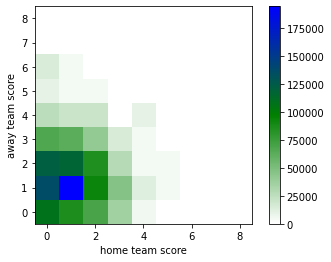

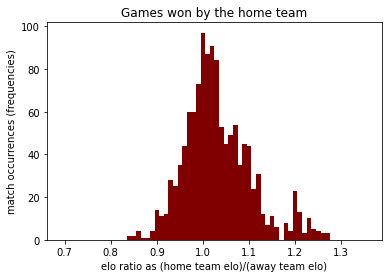

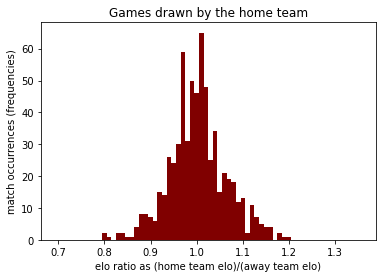

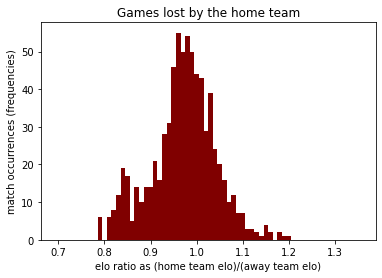

In [9]:

print(score_log)

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white","green","blue"])

print("Scores distribution of home teams vs away teams")
plt.xlabel("home team score")
plt.ylabel("away team score")
plt.imshow(score_log, origin='lower', interpolation='none', cmap=cmap)
plt.colorbar(orientation='vertical')
plt.show()

# print("Games won by home team")
# plt.xlabel("home/away team elo ratio")
# plt.ylabel("occurrences")
# plt.imshow(frequencies_home_win, origin='lower', interpolation='none', cmap=cmap)
# plt.colorbar(orientation='vertical')
# plt.show()
plot_graph( np.arange(0.7,1.35,0.01).tolist(),frequencies_home_win.tolist(),"Games won by the home team","elo ratio as (home team elo)/(away team elo)","match occurrences (frequencies)")
plot_graph( np.arange(0.7,1.35,0.01).tolist(),frequencies_home_draw.tolist(),"Games drawn by the home team","elo ratio as (home team elo)/(away team elo)","match occurrences (frequencies)")
plot_graph( np.arange(0.7,1.35,0.01).tolist(),frequencies_home_loss.tolist(),"Games lost by the home team","elo ratio as (home team elo)/(away team elo)","match occurrences (frequencies)")

# print("Games drawn by home team")
# plt.xlabel("home/away team elo ratio")
# plt.ylabel("occurrences")
# plot_graph()
# plt.imshow(frequencies_home_draw, origin='lower', interpolation='none', cmap=cmap)
# plt.colorbar(orientation='vertical')
# plt.show()


# print("Games lost by home team")
# plt.xlabel("home/away team elo ratio")
# plt.ylabel("occurrences")
# plt.imshow(frequencies_home_loss, origin='lower', interpolation='none', cmap = cmap)
# plt.colorbar(orientation='vertical')
# plt.show()


In [10]:
frequencies_home_draw[0]

0

In [11]:
frequencies_home_win[0]

0